# Hyperpolarized C13 EPI Reconstruction Demo

The C13 echo-planar imaging (EPI) sequence used to acquire this demonsration data is built off of the product/clinical 1H EPI sequence on GE scanners. It utilizes the Orchestra reconstruction to load and process the C13 data (phase correction, ramp-sampling, etc.) for both offline and on-scanner reconstruction and dicom generation.

Because of software licenses we cannot publicly share that code in its entirety. 
Please contact jeremy.gordon@ucsf.edu or peder.larson@ucsf.edu if you  would like access to the pulse sequence and reconstruction code.

This pseudo reconstruction code will pre-whiten the multichannel data and then generate coil combined images using the pyruvate data to estimate the sensitivity map. More information on this 'refpeak' reconstruction can be found in Zhu et al., "Coil combination methods for multi-channel hyperpolarized 13C imaging data from human studies" 
https://doi.org/10.1016/j.jmr.2019.01.015

## Install code, setup path

To run this code you will need to clone the hyperpolarized MRI toolbox
repository from github and add it to your matlab path. 
This can be done with the following command:
'git clone https://github.com/LarsonLab/hyperpolarized-mri-toolbox/'

This also requires the Optimization Toolbox (Matlab) or 'optim' toolbox (Octave) for the kinetic model fitting and Image Processing Toolbox ('image' in Octave) for plots


In [1]:
%addpath(genpath('/Users/plarson/Documents/GitHub/hyperpolarized-mri-toolbox/'))
%pkg load optim % for fitting functions to work in Octave
%pkg load image

In [2]:
% setup hyperpolarized-mri-toolbox
cd ../../
startup
cd 'recon/EPI demo'

    startup at line 2 column 1
loading optim
loading image


In [9]:
%% Load the EPI data
close all, clear all, clc
load brain_data_demo

X = size(chim,1)
Y = size(chim,2)
numCoils = size(chim,3)
numSlices = size(chim,4)
numFreqs = 3; %[Pyruvate, Lactate, Bicarbonate]
numFrames = 20;
chim = reshape(chim,[X Y numCoils numSlices numFreqs numFrames]);
chim = permute(chim,[1 2 4 3 7 5 6]);
size(chim)


X =  16
Y =  16
numCoils =  32
numSlices =  8
ans =

   16   16    8   32    1    3   20



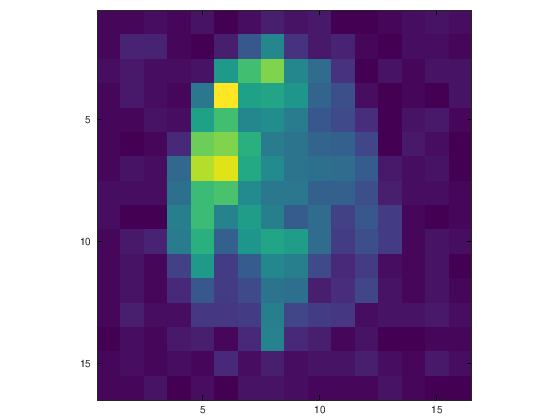

In [10]:
% pyruvate image slice 4, channel 12, time point 3

imagesc(abs(chim(:,:,4,12,1,1,3))), axis square

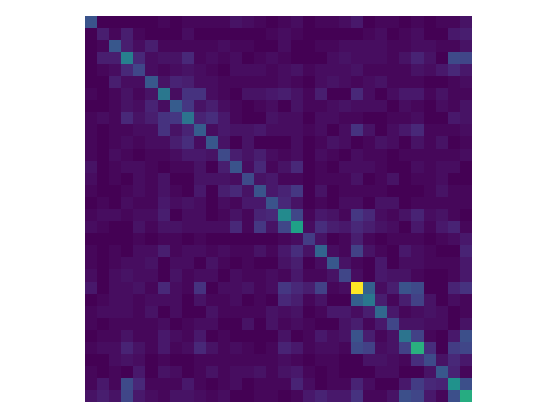

In [11]:
%% Pre-whiten the data
%Ensure you use noise-only data for pre-whitening
noise_data = chim(:,:,1,:,1,1,20);
[chim, ncm] = prewhitening_cc(chim, noise_data);

%Note that Ch. 23 is 'hot' relative to the other 31 elements
figure,imagesc(abs(ncm)); axis image off;


In [12]:
%% Reconstruct using the 'refpeak' method and sum-of-squares
im_refpeak = RefPeak_cc(chim);
im_sos = Sum_of_Square_cc(chim);

im_refpeak = squeeze(im_refpeak);
im_sos = squeeze(im_sos);


In [19]:
%% Compare area under the curve (AUC) for the two reconstructions

%Subtle difference for high SNR metabolites (pyruvate)
figure;
pyr_sos = abs(squeeze(sum(im_sos(:,:,:,1,:),5)));
clim = [0.05 0.8].*max(pyr_sos(:));
subplot(121),montage(permute(pyr_sos,[1 2 4 3]),'DisplayRange',clim,'Size',[3 3])
title('SoS Pyruvate')

pyr_ref = abs(squeeze(sum(im_refpeak(:,:,:,1,:),5)));
clim = [0.05 0.8].*max(pyr_ref(:));
subplot(122),montage(permute(pyr_ref,[1 2 4 3]),'DisplayRange',clim,'Size',[3 3])
title('Refpeak Pyruvate')
%set(gcf,'units','normalized','outerposition',[0.2 0.2 0.6 0.5])




error: print: directory C:\Users\PLarson\AppData\Local\Temp\1\tmpjno8iweo does not exist
error: called from
    _make_figures>safe_print at line 125 column 7
    _make_figures at line 49 column 13


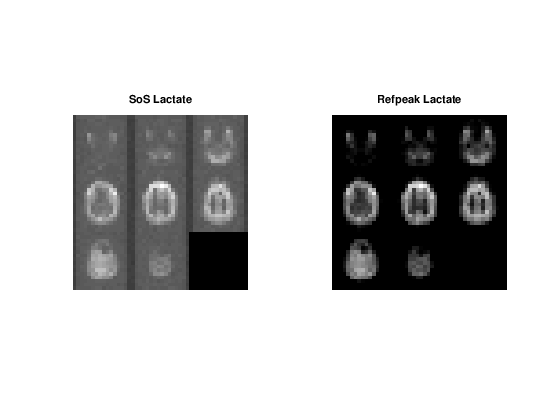

In [14]:
%More difference for medium SNR metabolites (lactate)
figure;
lac_sos = abs(squeeze(sum(im_sos(:,:,:,2,:),5)));
clim = [0.05 1].*max(lac_sos(:));
subplot(121),montage(permute(lac_sos,[1 2 4 3]),'DisplayRange',clim,'Size',[3 3])
title('SoS Lactate')

lac_ref = abs(squeeze(sum(im_refpeak(:,:,:,2,:),5)));
clim = [0.05 1].*max(lac_ref(:));
subplot(122),montage(permute(lac_ref,[1 2 4 3]),'DisplayRange',clim,'Size',[3 3])
title('Refpeak Lactate')
%set(gcf,'units','normalized','outerposition',[0.2 0.2 0.6 0.5])



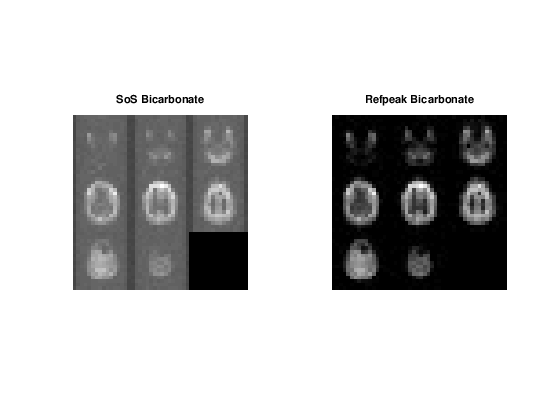

In [15]:
%Largest difference for noisiest metabolites (bicarbonate)
figure;
bic_sos = abs(squeeze(sum(im_sos(:,:,:,2,:),5)));
clim = [0.01 1].*max(bic_sos(:));
subplot(121),montage(permute(bic_sos,[1 2 4 3]),'DisplayRange',clim,'Size',[3 3])
title('SoS Bicarbonate')

bic_ref = abs(squeeze(sum(im_refpeak(:,:,:,2,:),5)));
clim = [0.01 1].*max(bic_ref(:));
subplot(122),montage(permute(bic_ref,[1 2 4 3]),'DisplayRange',clim,'Size',[3 3])
title('Refpeak Bicarbonate')
%set(gcf,'units','normalized','outerposition',[0.2 0.2 0.6 0.5])

In [ ]:
%% Use the 'refpeak' combined data to estimate kPL, AUC ratio, and mean arrival time

%Data were acquired with a variable flip angle across metabolites, constant
%through time.
flips = [20 30 30].* pi./180;
flips = repmat(flips,[numFrames 1]);
TR = 3; %temporal resolution (s)

%Threshold based on pyruvate AUC
mask = zeros(X,Y,numSlices);
thresh = 0.05;
mask(pyr_ref > thresh.*max(pyr_ref(:))) = 1;

%Intialize fit parameters
clear params_fixed params_est params_fit
R1P_est = 1/30; R1L_est = 1/25;  kPL_est = 0.02;
R1B_est = 1/30; kPB_est = 0.005;
params_fixed.R1P = R1P_est; params_fixed.R1L = R1L_est;
params_est.kPL = kPL_est; params_est.kPB = kPB_est; 
params_est.R1B = R1B_est;

mean_time_map = zeros(X,Y,numSlices,numFreqs);
kpl = zeros(X,Y,numSlices);
kpb = zeros(X,Y,numSlices);
lp_ratio = zeros(X,Y,numSlices);
bp_ratio = zeros(X,Y,numSlices);
for ii = 1:X
    for jj = 1:Y
        for kk = 1:numSlices
            %To minimize runtime, only fit if SNR is adequate
            if mask(ii,jj,kk)
                %Fit kPL and kPB
                params_fit = fit_pyr_kinetics(abs(squeeze(im_refpeak(ii,jj,kk,:,:))),TR,flips',params_fixed,params_est);
                kpl(ii,jj,kk) = params_fit.kPL;
                kpb(ii,jj,kk) = params_fit.kPB;
                
                %Estimate mean arrival time of pyruvate, lactate, and bicarb
                mean_time_map(ii,jj,kk,1) = compute_mean_time(abs(squeeze(im_refpeak(ii,jj,kk,1,:)))',TR);
                mean_time_map(ii,jj,kk,2) = compute_mean_time(abs(squeeze(im_refpeak(ii,jj,kk,2,:)))',TR);
                mean_time_map(ii,jj,kk,3) = compute_mean_time(abs(squeeze(im_refpeak(ii,jj,kk,3,:)))',TR);
                
                %Estimate AUC ratio
                lp_ratio(ii,jj,kk) = compute_AUCratio(abs(squeeze(im_refpeak(ii,jj,kk,[1 2],:))));
                bp_ratio(ii,jj,kk) = compute_AUCratio(abs(squeeze(im_refpeak(ii,jj,kk,[1 3],:))));
            end
        end
    end
end


** Warning: Cannot interrupt Octave on Windows


In [17]:
%% Display a subset of the results
%Note the difference in mean arrival time between pyruvate and lactate
figure;
subplot(121),montage(permute(mean_time_map(:,:,:,1),[1 2 4 3]),'DisplayRange', ... 
    [10 30],'Size',[3 3])
title('Pyruvate Mean Arrival Time')
subplot(122),montage(permute(mean_time_map(:,:,:,2),[1 2 4 3]),'DisplayRange', ... 
    [10 30],'Size',[3 3])
title('Lactate Mean Arrival Time')
%set(gcf,'units','normalized','outerposition',[0.2 0.2 0.6 0.5])



cfda95465f3a4b218cc75f8f08a283e8


In [18]:
%Note the similarity between kPL and lactate-to-pyuvater AUC ratio maps
figure;
subplot(121),montage(permute(lp_ratio,[1 2 4 3]),'Size',[3 3], ... 
    'DisplayRange',[0 1].*max(lp_ratio(:)))
title('k_{PL}')
subplot(122),montage(permute(kpl,[1 2 4 3]),'Size',[3 3], ...
    'DisplayRange',[0 1].*max(kpl(:)))
title('Lactate/Pyruvate Ratio')
%set(gcf,'units','normalized','outerposition',[0.2 0.2 0.6 0.5])

error: print: directory C:\Users\PLarson\AppData\Local\Temp\1\tmppah0w1go does not exist
error: called from
    _make_figures>safe_print at line 125 column 7
    _make_figures at line 49 column 13
